# Connecting initiators to jets & distinguish quark/gluon jets

Per event, the four-vector is given of the initiator partons. This information is stored into the .root file that is output by .runSoftDropSkinny. The structure is slightly different from the Recursive SoftDrop observables: per event there are 2 entries for each of the four-vector variables i.o. a number of entries corresponding to the number of splittings for each jet. This will give issues when extracting the data. This is solved by splitting the data into data of the partons and data of the jets (SoftDropped). \
Structure of jets: event -> jet -> jetentry \
Sturcuture of partons: event -> partonentry (almost always 2)

Next the four-vectors of the partons should be used to obtain a form of distance (like dr12?) for the partons. These can then be compared to the jets, and a link can be made between the partons and their corresponding jets: the initiators are the first partons to form jets, so it is nice to know which jets correspond to these. 

In [1]:
import ROOT
import uproot

import math as m
import numpy as np
import scipy as sp
import pandas as pd
import awkward as ak

import matplotlib.pyplot as plt
from matplotlib import colors

Welcome to JupyROOT 6.24/06


In [2]:
fileName = 'samples/07-09-2021_58MB_Pt120_tune14_10k_SD/JetToyHIResultSoftDropSkinny_old.root'
branches = uproot.open(fileName)['jetTreeSig'].arrays()

In [3]:
df = ak.to_pandas(branches)
df.head()

eventWeight    sigJetPt  sigJetEta  sigJetPhi  \
entry subentry subsubentry                                                  
0     0        0                    1.0  129.194639  -2.181834   6.021922   
               1                    1.0  129.194639  -2.181834   6.021922   
               2                    1.0  129.194639  -2.181834   6.021922   
               3                    1.0  129.194639  -2.181834   6.021922   
               4                    1.0  129.194639  -2.181834   6.021922   

                             sigJetM  sigJetArea  p1_jet_dR  p2_jet_dR  \
entry subentry subsubentry                                               
0     0        0            8.420125    0.513286   3.614601   0.026881   
               1            8.420125    0.513286   3.614601   0.026881   
               2            8.420125    0.513286   3.614601   0.026881   
               3            8.420125    0.513286   3.614601   0.026881   
               4            8.420125    0.513286   3.614601   0.026881   

                            sigJetRecur_nSD  sigJetRecur_dr12  \
entry subentry subsubentry                                      
0     0        0                        5.0          0.038962   
               1                        5.0          0.021944   
               2                        5.0          0.011159   
               3                        5.0          0.005370   
               4                        5.0          0.002930   

                            sigJetRecur_jetpt  sigJetRecur_z  partonsPt  \
entry subentry subsubentry                                                
0     0        0                   113.679328       0.391057  126.12564   
               1                    69.229175       0.439470  126.12564   
               2                    38.807065       0.131936  126.12564   
               3                    33.687262       0.182258  126.12564   
               4                    27.547556       0.227172  126.12564   

                            partonsEta  partonsPhi  partonsM  partonsPDG  
entry subentry subsubentry                                                
0     0        0             -0.348964    2.855384  0.000001          21  
               1             -0.348964    2.855384  0.000001          21  
               2             -0.348964    2.855384  0.000001          21  
               3             -0.348964    2.855384  0.000001          21  
               4             -0.348964    2.855384  0.000001          21

In [4]:

jet_data = ak.to_pandas(branches[['sigJetPt', 'sigJetEta', 'sigJetPhi', 'sigJetM', 'sigJetArea', 'p1_jet_dR', 'p2_jet_dR', 'sigJetRecur_nSD']])
jetRec_data = ak.to_pandas(branches[['sigJetRecur_dr12', 'sigJetRecur_jetpt', 'sigJetRecur_z']])
parton_data = ak.to_pandas(branches[['partonsPt', 'partonsEta', 'partonsPhi', 'partonsM', 'partonsPDG']])

# add partonsPDG to the jet data
jet_data['partonsPDG'] = np.nan
#jetRec_data['partonsPDG'] = np.nan

# number of events from dataframe
size = jet_data.index[-1][0] + 1

#print(jetRec_data.head())
#print(parton_data.tail())
jet_data.head()



sigJetPt  sigJetEta  sigJetPhi    sigJetM  sigJetArea  \
entry subentry                                                            
0     0         129.194639  -2.181834   6.021922   8.420125    0.513286   
      1          87.500972   0.008960   2.739309  16.517970    0.498336   
      2          37.844921   1.509155   3.173431   6.680464    0.488369   
1     0         405.069079   0.044764   3.528266  44.034188    0.508303   
      1         281.747158  -1.467919   0.145335  34.143812    0.518269   

                p1_jet_dR  p2_jet_dR  sigJetRecur_nSD  partonsPDG  
entry subentry                                                     
0     0          3.614601   0.026881              5.0         NaN  
      1          0.376127   3.739993              5.0         NaN  
      2          1.871449   4.642411              3.0         NaN  
1     0          0.192382   3.371172              9.0         NaN  
      1          3.276137   0.337545              5.0         NaN

In [5]:
parton_data.head()

partonsPt  partonsEta  partonsPhi  partonsM  partonsPDG
entry subentry                                                          
0     0         126.125640   -0.348964    2.855384  0.000001          21
      1         126.125640   -2.189788    5.996977  0.330000           2
1     0         361.015156    0.216420    3.614609  0.000000          21
      1         361.015156   -1.380366    0.473017  0.000007          21
2     0         162.424494   -0.809553    1.750876  0.000004          21

## Distance between objects

Distance can be calculated using: $$\Delta R^{(detector)}_{ij} = \sqrt{(\phi_i − \phi_j)^2 + (\eta_i − \eta_j)^2}$$

This is defined in the following function:

In [6]:
def DR(phi_i, phi_j, eta_i, eta_j):
    return m.sqrt((phi_i- phi_j)**2 + (eta_i - eta_j)**2)

Now we can calcluate distances using the four-vectors of two different objects, e.g. partons & jets.
This is then used to find the jets which are closest to the parton initiators. The four-vectors of the parton initiators have been provided in the dataset. 

For each parton we want to find the the jet that minimizes $\Delta R^{(detector)}_{ij}$. This observable will be determined for the parent parton of each jet of an event (the first entry in the jet's binary tree), since this can be seen as the origin of the jet. Linking the jets to the parton initiators we end up with sets of jets from which we now know the parent particle, since this has been given in the parton data: 1-6 quarks, 21 gluons, etc. 

Question: Should we use data for which a zcut has not been applied (zc = 0)? Sometimes the first splittings of jets are removed from the binary tree due to them being soft-scattering processes. However, we want to use the true origin of the jet, which might have been cut out of a dataset where a zcut is applied (this happens quite often). On the other hand, these initial soft-scattering processes would not affect $\phi$ or $\eta$ too much, most likely still linking the parton to the correct jet.
Answer: Simply using the non-recursive without zcut will give the real parent parton for each jet. Then a zcut can still be applied to the recursive softdrop algorithm

Update: Don't need to calculate dR anymore since this is now already done in the .runSoftDropSkinny script. The dRs wrt the partons are given for each jet in the new 

I will now go over the entire dataset, to figure out which jet belongs to which parton initiator.
In principle, the jet that gives the smallest $\Delta R$ for a parton initiator will be linked to that parton. However, in some cases this will not produce correct results. 
For instance, sometimes the reconstruction of the correct jet could not be done correctly (or the reconstruction algorithm skipped the jet?) and the jet will be missing from the dataset. This will result in an event with only 1 jet entry, or multiple jet entries but none of the jets corresponding to one of the particles (the other jets are offsprings of the first) which result in deltaR values higher than $\pi$ for one of the particles.

So a few checks need to be made:
- The event contains at least 2 partons (Not necessary? There seem to be always at least 2 particles, as expected from Pythia)
- The event contains more than 2 partons? (can this even happen?)
- The event contains at least 2 jets (Not necessary? Since I check for dR values < $\pi$ I expect to remove this effect)
- Both partons of the event will have $\Delta R$s smaller than $\pi$ with at least 1 of the jets of the event
- This cannot be the same jet!

In [7]:
p1_jet_nrs = np.zeros(size)
p2_jet_nrs = np.zeros(size)

p1_dRs = np.zeros(size)
p2_dRs = np.zeros(size)

def check_dR(dRs, dR_cut: int = 0.2):
    if any(i <= dR_cut for i in dRs):
        return np.argmin(dRs), np.min(dRs)
    else:
        return -1, -1


for iev in range(size):
    # obtain jet index numbers and correspond deltaR, store these in the arrays
    p1_jet_nr, p1_dR = check_dR(jet_data['p1_jet_dR'][iev])
    p2_jet_nr, p2_dR = check_dR(jet_data['p2_jet_dR'][iev])
    p1_jet_nrs[iev], p1_dRs[iev] = p1_jet_nr, p1_dR
    p2_jet_nrs[iev], p2_dRs[iev] = p2_jet_nr, p2_dR


    # pass partonsPDG value onto the jet_data dataframe
    # parton 1
    if p1_jet_nr == -1:
        pass
    else:
        jet_data['partonsPDG'][iev][p1_jet_nr] = parton_data['partonsPDG'][iev][0]

    # parton 2
    if p2_jet_nr == -1:
        pass
    else:
        jet_data['partonsPDG'][iev][p2_jet_nr] = parton_data['partonsPDG'][iev][1]


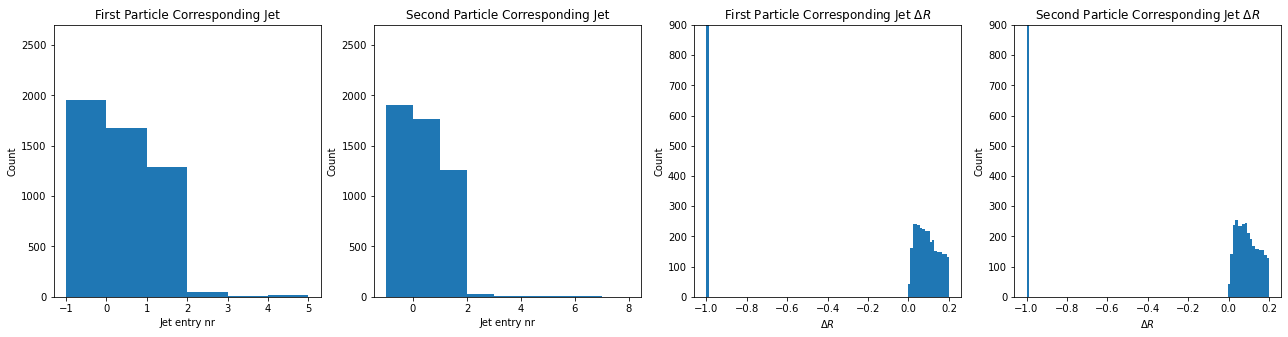

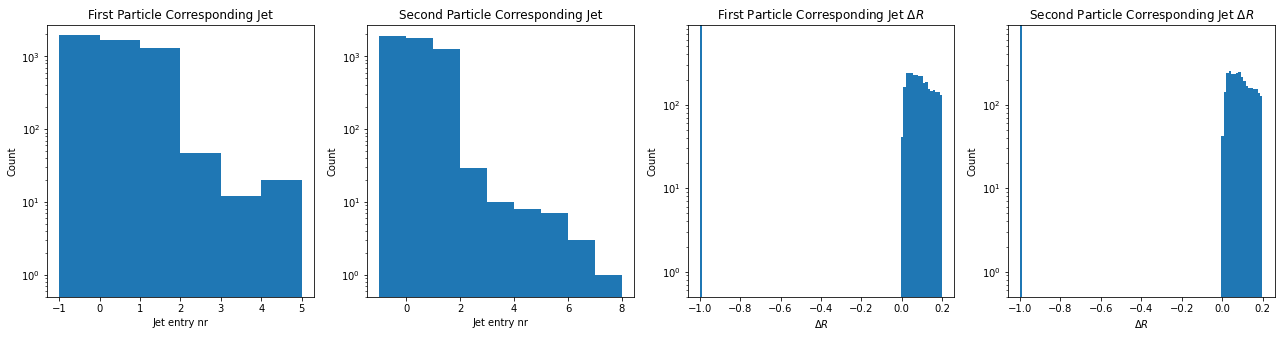

In [8]:
def plot_dR_info(axs):
    axs[0].hist(p1_jet_nrs, bins=int(np.max(p1_jet_nrs)- np.min(p1_jet_nrs)))
    axs[0].title.set_text('First Particle Corresponding Jet')
    axs[0].set_xlabel('Jet entry nr')
    axs[0].set_ylabel('Count')
    axs[0].set_ylim(top=2700)
    axs[1].hist(p2_jet_nrs, bins=int(np.max(p2_jet_nrs)- np.min(p2_jet_nrs)))
    axs[1].title.set_text('Second Particle Corresponding Jet')
    axs[1].set_xlabel('Jet entry nr')
    axs[1].set_ylabel('Count')
    axs[1].set_ylim(top=2700)
    axs[2].hist(p1_dRs, bins=100)
    axs[2].title.set_text(r'First Particle Corresponding Jet $\Delta R$')
    axs[2].set_xlabel(r'$\Delta R$')
    axs[2].set_ylabel('Count')
    axs[2].set_ylim(top=900)
    axs[3].hist(p2_dRs, bins=100)
    axs[3].title.set_text(r'Second Particle Corresponding Jet $\Delta R$')
    axs[3].set_xlabel(r'$\Delta R$')
    axs[3].set_ylabel('Count')
    axs[3].set_ylim(top=900)
    return

fig, axs = plt.subplots(1, 4, figsize=(22, 5))
fig.patch.set_facecolor('white')
plot_dR_info(axs)
plt.show()

fig2, axs2 = plt.subplots(1, 4, figsize=(22, 5))
fig2.patch.set_facecolor('white')
[ax.set_yscale('log') for ax in axs2]
[ax.set_ylim(bottom=0.5) for ax in axs2]
plot_dR_info(axs2)
plt.show()

In [9]:
jet_data.head()

sigJetPt  sigJetEta  sigJetPhi    sigJetM  sigJetArea  \
entry subentry                                                            
0     0         129.194639  -2.181834   6.021922   8.420125    0.513286   
      1          87.500972   0.008960   2.739309  16.517970    0.498336   
      2          37.844921   1.509155   3.173431   6.680464    0.488369   
1     0         405.069079   0.044764   3.528266  44.034188    0.508303   
      1         281.747158  -1.467919   0.145335  34.143812    0.518269   

                p1_jet_dR  p2_jet_dR  sigJetRecur_nSD  partonsPDG  
entry subentry                                                     
0     0          3.614601   0.026881              5.0         2.0  
      1          0.376127   3.739993              5.0         NaN  
      2          1.871449   4.642411              3.0         NaN  
1     0          0.192382   3.371172              9.0        21.0  
      1          3.276137   0.337545              5.0         NaN

In [10]:
print('Gluon jets:', np.count_nonzero(jet_data['partonsPDG'] == 21) )
print('Quark jets:', np.count_nonzero(np.abs(jet_data['partonsPDG']).isin(range(1,7))) )

Gluon jets: 3252
Quark jets: 2885


In [11]:
g_jets = jet_data[jet_data['partonsPDG'] == 21 ]
q_jets = jet_data[np.abs(jet_data['partonsPDG']).isin(range(1,7))]

# apply pt cut, eta cut - ignore the UserWarning, because the result is exactly what we want
cg_jets = g_jets[g_jets['sigJetEta'] <= 2][g_jets['sigJetEta'] >= -2][g_jets['sigJetPt'] >= 130]
cq_jets = q_jets[q_jets['sigJetEta'] <= 2][q_jets['sigJetEta'] >= -2][q_jets['sigJetPt'] >= 130]

/var/folders/2x/_czh2l1x4sd_pgz7n5rvj4p80000gn/T/ipykernel_23759/2235371076.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cg_jets = g_jets[g_jets['sigJetEta'] <= 2][g_jets['sigJetEta'] >= -2][g_jets['sigJetPt'] >= 130]
/var/folders/2x/_czh2l1x4sd_pgz7n5rvj4p80000gn/T/ipykernel_23759/2235371076.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cq_jets = q_jets[q_jets['sigJetEta'] <= 2][q_jets['sigJetEta'] >= -2][q_jets['sigJetPt'] >= 130]


In [12]:
g_jets.head()

sigJetPt  sigJetEta  sigJetPhi    sigJetM  sigJetArea  \
entry subentry                                                            
1     0         405.069079   0.044764   3.528266  44.034188    0.508303   
2     0         177.368018  -0.682919   1.728660  18.506593    0.513286   
      1         153.779092   0.973012   4.879201  25.869341    0.523253   
4     1         170.854541   1.395826   0.448849  15.315490    0.528236   
5     0         134.432609   0.842848   4.326091  16.766044    0.498336   

                p1_jet_dR  p2_jet_dR  sigJetRecur_nSD  partonsPDG  
entry subentry                                                     
1     0          0.192382   3.371172              9.0        21.0  
2     0          0.131728   3.561669              6.0        21.0  
      1          3.595395   0.077851              6.0        21.0  
4     1          3.050640   0.135384              5.0        21.0  
5     0          0.026105   3.136865              6.0        21.0

In [13]:
cg_jets.head()

sigJetPt  sigJetEta  sigJetPhi    sigJetM  sigJetArea  \
entry subentry                                                            
1     0         405.069079   0.044764   3.528266  44.034188    0.508303   
2     0         177.368018  -0.682919   1.728660  18.506593    0.513286   
      1         153.779092   0.973012   4.879201  25.869341    0.523253   
4     1         170.854541   1.395826   0.448849  15.315490    0.528236   
5     0         134.432609   0.842848   4.326091  16.766044    0.498336   

                p1_jet_dR  p2_jet_dR  sigJetRecur_nSD  partonsPDG  
entry subentry                                                     
1     0          0.192382   3.371172              9.0        21.0  
2     0          0.131728   3.561669              6.0        21.0  
      1          3.595395   0.077851              6.0        21.0  
4     1          3.050640   0.135384              5.0        21.0  
5     0          0.026105   3.136865              6.0        21.0

## Cut survival rate

In [14]:
print('Gluon jets:', len(g_jets))
print('Gluon jets after cuts:', len(cg_jets))
print('Fraction gluon jets survived:', len(cg_jets)/len(g_jets))

print('Quark jets:', len(q_jets))
print('Quark jets after cuts:', len(cq_jets))
print('Fraction quarks jets survived:', len(cq_jets)/len(q_jets))

print('Cut survival rate gluon jets / Cut survival rate quarks:', (len(cg_jets)/ len(g_jets)) / (len(cq_jets)/len(q_jets)))

Gluon jets: 3252
Gluon jets after cuts: 1537
Fraction gluon jets survived: 0.4726322263222632
Quark jets: 2885
Quark jets after cuts: 1475
Fraction quarks jets survived: 0.511265164644714
Cut survival rate gluon jets / Cut survival rate quarks: 0.9244365918235453


## Jet mass & Pt distributions

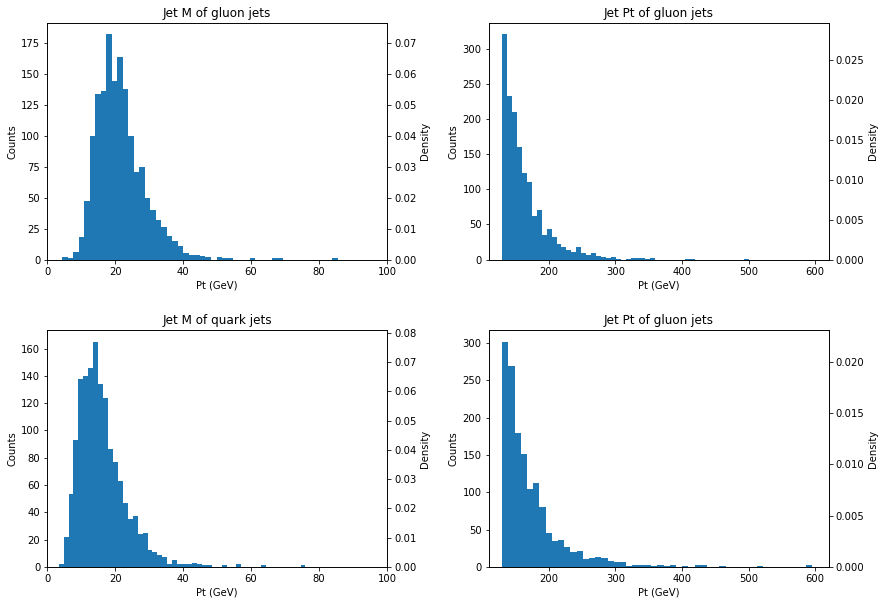

In [15]:
fig3, axs3 = plt.subplots(2,2, figsize=(14, 10))
y_axs2 = [[ax.twinx() for ax in ax_array] for ax_array in axs3] # add second y axes
fig3.patch.set_facecolor('white')
fig3.subplots_adjust(hspace=0.3, wspace=0.3)

axs3[0,0].hist(cg_jets['sigJetM'], bins=50)
axs3[0,0].title.set_text("Jet M of gluon jets")
axs3[0,0].set_xlim((0,100))
y_axs2[0][0].hist(cg_jets['sigJetM'], bins=50, density=True)


axs3[0,1].hist(cg_jets['sigJetPt'], bins=50)
axs3[0,1].title.set_text("Jet Pt of gluon jets")
axs3[0,1].set_xlim((110,620))
y_axs2[0][1].hist(cg_jets['sigJetPt'], bins=50, density=True)

axs3[1,0].hist(cq_jets['sigJetM'], bins=50)
axs3[1,0].title.set_text("Jet M of quark jets")
axs3[1,0].set_xlim((0,100))
y_axs2[1][0].hist(cq_jets['sigJetM'], bins=50, density=True)

axs3[1,1].hist(cq_jets['sigJetPt'], bins=50)
axs3[1,1].title.set_text("Jet Pt of gluon jets")
axs3[1,1].set_xlim((110,620))
y_axs2[1][1].hist(cq_jets['sigJetPt'], bins=50, density=True)

[[ax.set_ylabel("Counts") for ax in ax_array]for ax_array in axs3]
[[ax.set_ylabel("Density") for ax in ax_array]for ax_array in y_axs2]
[[ax.set_xlabel("Pt (GeV)") for ax in ax_array] for ax_array in axs3]

plt.tight_layout
plt.show()


In [16]:
# Not necessary, we can just apply cuts to jetRec_data with jet_data['partonsPDG']
#jetRec_data['partonsPDG'] = jet_data['partonsPDG']

## Now for the Recursive SoftDropped data

We can simply use the data from jet_data to apply cuts to jetRec_data.
e.g. <br><br>
jetRec_data[jet_data['sigJetPt'] >= 130] <br><br>
works!

In [17]:
jetRec_data.head(20)

sigJetRecur_dr12  sigJetRecur_jetpt  sigJetRecur_z
entry subentry subsubentry                                                    
0     0        0                    0.038962         113.679328       0.391057
               1                    0.021944          69.229175       0.439470
               2                    0.011159          38.807065       0.131936
               3                    0.005370          33.687262       0.182258
               4                    0.002930          27.547556       0.227172
      1        0                    0.123285          82.121450       0.133018
               1                    0.088098          70.639097       0.129332
               2                    0.038919          61.505219       0.179104
               3                    0.031718          50.494682       0.267085
               4                    0.009094          37.008719       0.215643
      2        0                    0.100337          33.742780       0.276364
               1                    0.065400          24.438433       0.182952
               2                    0.019838          18.486101       0.337223
1     0        0                    0.147428         394.769860       0.300883
               1                    0.132673         276.618416       0.289236
               2                    0.070987         173.863196       0.255452
               3                    0.034476         115.932638       0.273700
               4                    0.022952          84.210576       0.453807
               5                    0.015130          45.998157       0.160921
               6                    0.010784          38.596652       0.320538

### Filters and Cuts, a little explanation

Filter out the quark and gluon jets from the recursive SoftDropped dataset. These are then stored in two new datasets to be used to find the Lund planes. Afterwards, filters for Eta and Pt are applied again on the original quars & gluons data and recursive jetPt data. Should filter be done for sigJetPt instead?

The filters can be applied in this way, because any cuts to the quarks and gluons data are on a jet basis, and the entire jet will be filtered out of the recursive jet dataset. However, the warnings will be output stating that the Boolean Series key will be reindexed to match DataFrame index. I did not find a way to get rid of the warning, however what the warning states is actually exactly what we want... good job Pandas!

Cut on $P_T$ explanation: We apply a cut on jet $P_T$ where we remove jets of $P_T < 130 GeV$. We do not cut constituents of the leading branch, but the jet $P_T$ itself, because we want to look at jets that originate from a hard-process. The splittings in the jet can then be of harder- or softer-processes, but remember that there is a Z-Cut of 0.1 which has already been applied!

In [18]:
# filter quark and gluon recursive SoftDropped dataset using the normal jet_data set
gR_jets = jetRec_data[jet_data['partonsPDG'] == 21]
qR_jets = jetRec_data[np.abs(jet_data['partonsPDG'].isin(range(1,7)))]

# apply pt cut, eta cut
cgR_jets = gR_jets[(g_jets['sigJetEta'] <= 2) & (g_jets['sigJetEta'] >= -2) & (g_jets['sigJetPt'] >= 130)]
cqR_jets = qR_jets[(q_jets['sigJetEta'] <= 2) & (q_jets['sigJetEta'] >= -2) & (q_jets['sigJetPt'] >= 130)]

/var/folders/2x/_czh2l1x4sd_pgz7n5rvj4p80000gn/T/ipykernel_23759/3574872214.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  gR_jets = jetRec_data[jet_data['partonsPDG'] == 21]
/var/folders/2x/_czh2l1x4sd_pgz7n5rvj4p80000gn/T/ipykernel_23759/3574872214.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  qR_jets = jetRec_data[np.abs(jet_data['partonsPDG'].isin(range(1,7)))]
/var/folders/2x/_czh2l1x4sd_pgz7n5rvj4p80000gn/T/ipykernel_23759/3574872214.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cgR_jets = gR_jets[(g_jets['sigJetEta'] <= 2) & (g_jets['sigJetEta'] >= -2) & (g_jets['sigJetPt'] >= 130)]
/var/folders/2x/_czh2l1x4sd_pgz7n5rvj4p80000gn/T/ipykernel_23759/3574872214.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cqR_jets = qR_jets[(q_jets['sigJetEta'] <= 2) & (q_jets['sigJetEta'] >= -2) & (q_jets['sigJetPt'] >= 130)]


In [19]:
g_jets.head(30)

sigJetPt  sigJetEta  sigJetPhi    sigJetM  sigJetArea  \
entry subentry                                                            
1     0         405.069079   0.044764   3.528266  44.034188    0.508303   
2     0         177.368018  -0.682919   1.728660  18.506593    0.513286   
      1         153.779092   0.973012   4.879201  25.869341    0.523253   
4     1         170.854541   1.395826   0.448849  15.315490    0.528236   
5     0         134.432609   0.842848   4.326091  16.766044    0.498336   
10    1         112.965123  -1.058999   1.365947   8.581096    0.493353   
11    0         154.029094  -0.236500   1.330104  17.678617    0.478402   
13    1         183.384362   0.611274   1.507167  28.307720    0.508303   
15    1         121.748961   1.026440   5.812664  16.964691    0.508303   
17    1         105.122374  -0.516271   3.180464  15.586261    0.493353   
22    1         115.557451   0.726849   1.908461  12.700066    0.503319   
23    0         117.560756  -1.961180   6.049419  12.996820    0.518269   
      1          99.537026   0.168626   3.097114  22.772839    0.513286   
24    0         116.043317   0.714504   0.900285  12.148554    0.498336   
25    1         115.326343   1.584342   4.827766  24.206724    0.508303   
26    0         132.660873   1.768266   3.450318  17.857754    0.478402   
      1         120.318322   0.261239   0.245432  20.761357    0.498336   
27    0         141.668140   0.135793   2.741178  18.660877    0.503319   
35    0         154.656396  -0.181193   0.816257  17.567785    0.493353   
38    0         142.374054  -1.420721   4.164083  17.037095    0.498336   
40    0         148.175408  -1.814487   5.904714  28.453742    0.493353   
      1         138.263630  -1.848697   2.872878  11.938195    0.493353   
41    1         135.391456   1.733599   3.528814  15.884472    0.508303   
42    0         131.477646  -0.051481   2.325371  15.118024    0.503319   
44    0         211.557623  -0.982691   4.250256  20.754114    0.503319   
      1         208.375155   0.770671   1.160468  31.097704    0.498336   
46    1          67.792934   0.034446   0.862977  11.172061    0.503319   
48    1         169.167923   0.339505   1.009158  21.032501    0.483386   
49    0         122.337948  -0.449796   4.534768  17.467631    0.503319   
50    0         162.784731  -1.287826   1.180595  22.897954    0.518269   

                p1_jet_dR  p2_jet_dR  sigJetRecur_nSD  partonsPDG  
entry subentry                                                     
1     0          0.192382   3.371172              9.0        21.0  
2     0          0.131728   3.561669              6.0        21.0  
      1          3.595395   0.077851              6.0        21.0  
4     1          3.050640   0.135384              5.0        21.0  
5     0          0.026105   3.136865              6.0        21.0  
10    1          0.104667   3.045751              4.0        21.0  
11    0          0.148174   3.025168              4.0        21.0  
13    1          0.050620   3.119560              5.0        21.0  
15    1          3.106748   0.063834              5.0        21.0  
17    1          0.127145   3.526610              1.0        21.0  
22    1          0.056539   3.657979              5.0        21.0  
23    0          0.100997   3.767496              3.0        21.0  
      1          3.734733   0.133594              6.0        21.0  
24    0          0.084996   3.467450              6.0        21.0  
25    1          0.025555   3.144817              7.0        21.0  
26    0          0.052233   3.488920              5.0        21.0  
      1          3.459293   0.065373              5.0        21.0  
27    0          0.071215   3.713327              6.0        21.0  
35    0          3.390862   0.199000              3.0        21.0  
38    0          3.946954   0.027644              4.0        21.0  
40    0          3.045502   0.140809              5.0        21.0  
      1          0.028899   3.131636              2.0

In [20]:
gR_jets.head(30)

sigJetRecur_dr12  sigJetRecur_jetpt  sigJetRecur_z
entry subentry subsubentry                                                    
1     0        0                    0.147428         394.769860       0.300883
               1                    0.132673         276.618416       0.289236
               2                    0.070987         173.863196       0.255452
               3                    0.034476         115.932638       0.273700
               4                    0.022952          84.210576       0.453807
               5                    0.015130          45.998157       0.160921
               6                    0.010784          38.596652       0.320538
               7                    0.009027          26.225170       0.154865
               8                    0.002373          22.163926       0.308485
2     0        0                    0.037033         164.370537       0.122662
               1                    0.040539         144.217431       0.260949
               2                    0.034910         106.584660       0.156392
               3                    0.019276          89.916004       0.300335
               4                    0.013369          62.913511       0.433358
               5                    0.007417          35.649452       0.364830
      1        0                    0.172795         141.458658       0.378668
               1                    0.080265          77.671221       0.280836
               2                    0.066015          55.873469       0.164345
               3                    0.039067          46.692204       0.175364
               4                    0.018588          38.504405       0.169267
               5                    0.013861          31.987039       0.103371
4     1        0                    0.089091         157.076808       0.451642
               1                    0.065875          78.442010       0.181462
               2                    0.041371          61.583078       0.214179
               3                    0.017943          48.400209       0.430105
               4                    0.008222          27.584094       0.479115
5     0        0                    0.166026         123.793319       0.132175
               1                    0.088222         102.246201       0.225632
               2                    0.068327          79.176219       0.311651
               3                    0.057085          54.527350       0.294822

In [21]:
print('Gluon jet number splits leading branch:', len(gR_jets))
print('Quark jet number splits leading branch:', len(qR_jets))
print('Gluon jet number splits leading branch after cuts:', len(cgR_jets))
print('Quark jet number splits leading branch after cuts:', len(cqR_jets))


Gluon jet number splits leading branch: 15939
Quark jet number splits leading branch: 8369
Gluon jet number splits leading branch after cuts: 7620
Quark jet number splits leading branch after cuts: 4175


## Lund planes of quark and gluon jets

Apply knowledge of anAliPy_lund.ipynb in order to build and compare Lund planes of the quark and gluon jet's leading branch. 
The Lund planes will be made for both the full recursive quark/gluon dataset (with only a zcut of 0.1 which was already applied when SoftDrop ran) as well as for cuts applied to $\eta$ and $P_T$.

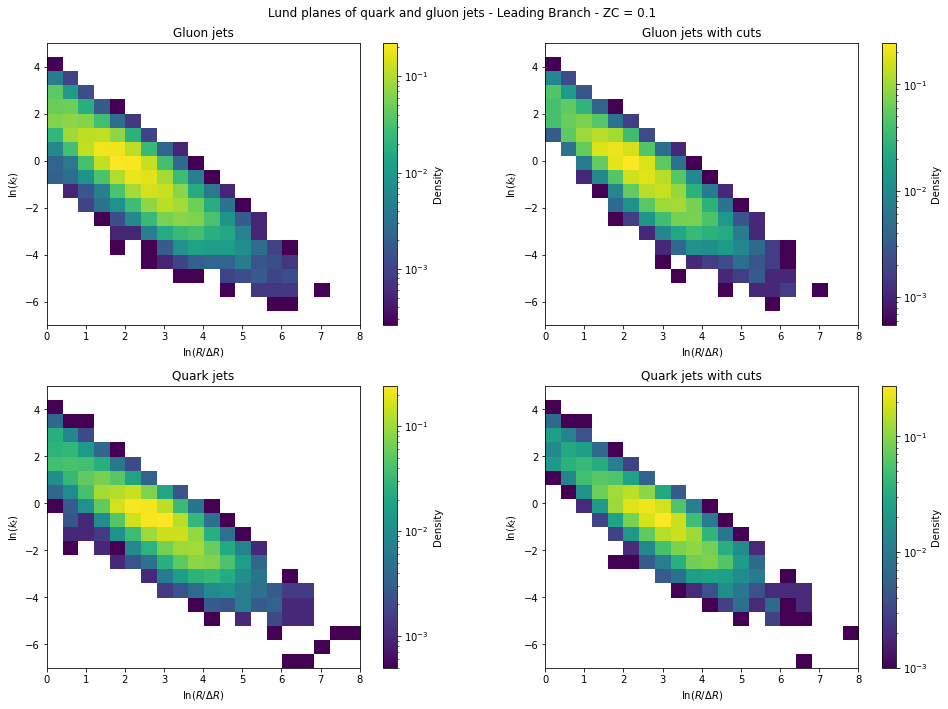

In [22]:
fig4, axs4 = plt.subplots(2,2, figsize=(14, 10))
fig4.patch.set_facecolor('white')
fig4.subplots_adjust(hspace=0.3)
fig4.suptitle('Lund planes of quark and gluon jets - Leading Branch - ZC = 0.1')

titles = ['Gluon jets', 'Gluon jets with cuts', 'Quark jets', 'Quark jets with cuts']

for i, jetset in enumerate([gR_jets, cgR_jets, qR_jets, cqR_jets]):
    kts = jetset['sigJetRecur_z'] * jetset['sigJetRecur_jetpt'] * jetset['sigJetRecur_dr12']
    H, xedges, yedges = np.histogram2d(np.log(0.4/jetset['sigJetRecur_dr12']), np.log(kts), range=[[0, 8], [-7, 5]], bins=20, normed=True)
    im = axs4[int(i/2), i%2].imshow(H.T, interpolation='nearest', origin='lower', norm=colors.LogNorm(), extent=[xedges[0], xedges[-1],
            yedges[0], yedges[-1]], aspect=0.6)
    fig.colorbar(im, ax=axs4[int(i/2), i%2], label='Density')
    axs4[int(i/2), i%2].set_xlabel(r'$\ln (R/\Delta R)$')
    axs4[int(i/2), i%2].set_ylabel(r'$\ln (k_t)$')
    axs4[int(i/2), i%2].title.set_text(titles[i])

plt.tight_layout()
plt.show()

## Number of splittings per gluon or quark jet

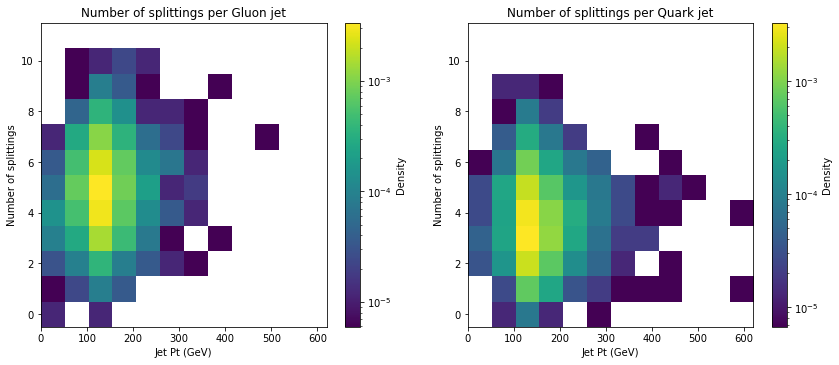

In [23]:
fig5, axs5 = plt.subplots(1,2, sharex=True, sharey=True, figsize=(12, 5))
fig5.patch.set_facecolor('white')

for i, (jetset, title) in enumerate(zip([g_jets, q_jets], ['Gluon', 'Quark'])):
    
    H, xedges, yedges = np.histogram2d(jetset['sigJetPt'], jetset['sigJetRecur_nSD'],range=[[0,620],[-0.5,11.5]], bins=12, density=True)
    im5 = axs5[i].imshow(H.T, interpolation='nearest', origin='lower', norm=colors.LogNorm(), extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
            aspect=55)
    fig.colorbar(im5, ax=axs5[i], label='Density')
    axs5[i].title.set_text('Number of splittings per {} jet'.format(title))
    axs5[i].set_xlabel('Jet Pt (GeV)')
    axs5[i].set_ylabel('Number of splittings')
    axs5[i].set_xlim(right=620)
    axs5[i].yaxis.set_tick_params(labelbottom=True)

plt.tight_layout()
plt.show()

### And for only hard scatterings: $P_T >= 130$ GeV

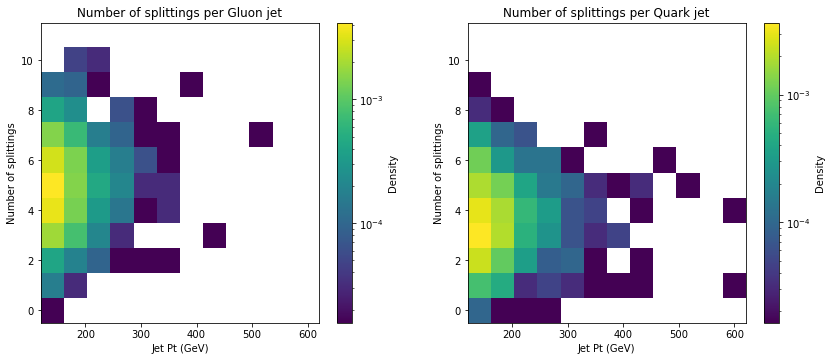

In [24]:
fig5, axs5 = plt.subplots(1,2, sharex=True, sharey=True, figsize=(12, 5))
fig5.patch.set_facecolor('white')

for i, (jetset, title) in enumerate(zip([cg_jets, cq_jets], ['Gluon', 'Quark'])):
    
    H, xedges, yedges = np.histogram2d(jetset['sigJetPt'], jetset['sigJetRecur_nSD'],range=[[120,620],[-0.5,11.5]], bins=12, density=True)
    im5 = axs5[i].imshow(H.T, interpolation='nearest', origin='lower', norm=colors.LogNorm(), extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
            aspect=45)
    fig.colorbar(im5, ax=axs5[i], label='Density')
    axs5[i].title.set_text('Number of splittings per {} jet'.format(title))
    axs5[i].set_xlabel('Jet Pt (GeV)')
    axs5[i].set_ylabel('Number of splittings')
    axs5[i].set_xlim(right=620)
    axs5[i].yaxis.set_tick_params(labelbottom=True)

plt.tight_layout()
plt.show()

## Distributions of splitting angle $\Delta R$

$\Delta R$ s given for the constituents of the leading-branch of the jets

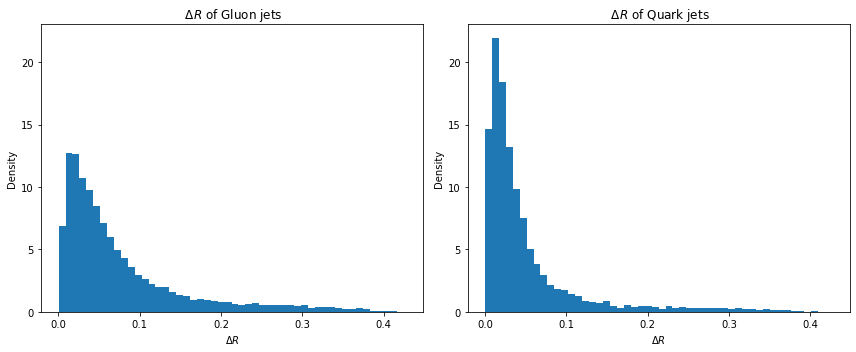

In [25]:
fig6, axs6 = plt.subplots(1,2, sharex=True, sharey=True, figsize=(12, 5))
fig6.patch.set_facecolor('white')

for i, (jetset, title) in enumerate(zip([gR_jets, qR_jets], ['Gluon', 'Quark'])):
    axs6[i].hist(jetset['sigJetRecur_dr12'], bins=50, density=True)
    axs6[i].title.set_text(r' $\Delta R$ of {} jets'.format(title))
    axs6[i].set_xlabel(r'$\Delta R$')
    axs6[i].set_ylabel('Density')
    #axs6[i].set_xlim(right=620)
    axs6[i].yaxis.set_tick_params(labelbottom=True)

plt.tight_layout()
plt.show()

## Try with new runSoftDropSkinny.cc code

In this new code, the linking between parton initiators and jets has already been performed. The cut to $\Delta R$ of 0.2 has been applied in this code. If a different cut is required, this should be changed in the runSoftDropSkinny.cc file. The "p1_jet_dR" and "p2_jet_dR" vectors are no longer required (at least for now) and have not been added to the new resulting dataset. 

Now to test if the results are the same:

In [26]:
fileName2 = 'samples/07-09-2021_58MB_Pt120_tune14_10k_SD/JetToyHIResultSoftDropSkinny.root'
branches2 = uproot.open(fileName2)['jetTreeSig'].arrays()

df2 = ak.to_pandas(branches2)
df2.head()

jet_data2 = ak.to_pandas(branches2[['sigJetPt', 'sigJetEta', 'sigJetPhi', 'sigJetM', 'sigJetArea', 'sigJetRecur_nSD', 'jetInitPDG']])
jetRec_data2 = ak.to_pandas(branches2[['sigJetRecur_dr12', 'sigJetRecur_jetpt', 'sigJetRecur_z']])
parton_data2 = ak.to_pandas(branches2[['partonsPt', 'partonsEta', 'partonsPhi', 'partonsM', 'partonsPDG']])

# number of events from dataframe
size2 = jet_data.index[-1][0] + 1

#print(jetRec_data.head())
#print(parton_data.tail())
jet_data2.head(20)

sigJetPt  sigJetEta  sigJetPhi    sigJetM  sigJetArea  \
entry subentry                                                            
0     0         129.194639  -2.181834   6.021922   8.420125    0.513286   
      1          87.500972   0.008960   2.739309  16.517970    0.498336   
      2          37.844921   1.509155   3.173431   6.680464    0.488369   
1     0         405.069079   0.044764   3.528266  44.034188    0.508303   
      1         281.747158  -1.467919   0.145335  34.143812    0.518269   
      2         141.350725  -1.738956   1.765061  10.668320    0.548170   
      3         117.045486   1.756352   5.883461  24.319758    0.533219   
      4          41.663332  -0.790145   0.497663   9.999140    0.483386   
      5          22.741272   1.875138   2.761568   5.594350    0.493353   
      6          12.957812   0.321892   1.081346   3.671172    0.563120   
2     0         177.368018  -0.682919   1.728660  18.506593    0.513286   
      1         153.779092   0.973012   4.879201  25.869341    0.523253   
      2          27.278497  -2.100130   4.164031   6.990849    0.513286   
      3          12.463246   1.533173   2.008995   5.098953    0.498336   
      4          10.989184  -2.117473   4.843554   4.653179    0.478402   
3     0         140.939017   1.628143   2.406914   8.951758    0.493353   
      1          87.683789   0.718948   5.954948  13.278414    0.503319   
      2          53.401915  -0.129549   4.807448  12.162624    0.488369   
4     0         200.314727   0.936224   3.919052  20.034068    0.478402   
      1         170.854541   1.395826   0.448849  15.315490    0.528236   

                sigJetRecur_nSD  jetInitPDG  
entry subentry                               
0     0                     5.0         2.0  
      1                     5.0         NaN  
      2                     3.0         NaN  
1     0                     9.0        21.0  
      1                     5.0         NaN  
      2                     3.0         NaN  
      3                     3.0         NaN  
      4                     5.0         NaN  
      5                     4.0         NaN  
      6                     2.0         NaN  
2     0                     6.0        21.0  
      1                     6.0        21.0  
      2                     5.0         NaN  
      3                     6.0         NaN  
      4                     3.0         NaN  
3     0                     2.0         1.0  
      1                     7.0         NaN  
      2                     5.0         NaN  
4     0                     2.0         NaN  
      1                     5.0        21.0

In [27]:
g_jets2 = jet_data2[jet_data2['jetInitPDG'] == 21 ]
q_jets2 = jet_data2[(jet_data2['jetInitPDG'] >= -6) & (jet_data2['jetInitPDG'] <= 6)]

# apply pt cut, eta cut - ignore the UserWarning, because the result is exactly what we want
cg_jets2 = g_jets2[g_jets2['sigJetEta'] <= 2][g_jets2['sigJetEta'] >= -2][g_jets2['sigJetPt'] >= 130]
cq_jets2 = q_jets2[q_jets2['sigJetEta'] <= 2][q_jets2['sigJetEta'] >= -2][q_jets2['sigJetPt'] >= 130]

/var/folders/2x/_czh2l1x4sd_pgz7n5rvj4p80000gn/T/ipykernel_23759/3456827137.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cg_jets2 = g_jets2[g_jets2['sigJetEta'] <= 2][g_jets2['sigJetEta'] >= -2][g_jets2['sigJetPt'] >= 130]
/var/folders/2x/_czh2l1x4sd_pgz7n5rvj4p80000gn/T/ipykernel_23759/3456827137.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cq_jets2 = q_jets2[q_jets2['sigJetEta'] <= 2][q_jets2['sigJetEta'] >= -2][q_jets2['sigJetPt'] >= 130]


In [28]:
print('Gluon jets:', len(g_jets2))
print('Gluon jets after cuts:', len(cg_jets2))
print('Fraction gluon jets survived:', len(cg_jets2)/len(g_jets2))

print('Quark jets:', len(q_jets2))
print('Quark jets after cuts:', len(cq_jets2))
print('Fraction quarks jets survived:', len(cq_jets2)/len(q_jets2))

print('Cut survival rate gluon jets / Cut survival rate quarks:', (len(cg_jets2)/ len(g_jets2)) / (len(cq_jets2)/len(q_jets2)))

Gluon jets: 3252
Gluon jets after cuts: 1537
Fraction gluon jets survived: 0.4726322263222632
Quark jets: 2885
Quark jets after cuts: 1475
Fraction quarks jets survived: 0.511265164644714
Cut survival rate gluon jets / Cut survival rate quarks: 0.9244365918235453


In [29]:
# filter quark and gluon recursive SoftDropped dataset using the normal jet_data set
gR_jets2 = jetRec_data2[jet_data2['jetInitPDG'] == 21]
qR_jets2 = jetRec_data2[(jet_data2['jetInitPDG'] >= -6) & (jet_data2['jetInitPDG'] <= 6)]

# apply pt cut, eta cut
cgR_jets2 = gR_jets2[(g_jets2['sigJetEta'] <= 2) & (g_jets2['sigJetEta'] >= -2) & (g_jets2['sigJetPt'] >= 130)]
cqR_jets2 = qR_jets2[(q_jets2['sigJetEta'] <= 2) & (q_jets2['sigJetEta'] >= -2) & (q_jets2['sigJetPt'] >= 130)]

print('Gluon jet number splits leading branch:', len(gR_jets2))
print('Quark jet number splits leading branch:', len(qR_jets2))
print('Gluon jet number splits leading branch after cuts:', len(cgR_jets2))
print('Quark jet number splits leading branch after cuts:', len(cqR_jets2))

/var/folders/2x/_czh2l1x4sd_pgz7n5rvj4p80000gn/T/ipykernel_23759/370992427.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  gR_jets2 = jetRec_data2[jet_data2['jetInitPDG'] == 21]
/var/folders/2x/_czh2l1x4sd_pgz7n5rvj4p80000gn/T/ipykernel_23759/370992427.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  qR_jets2 = jetRec_data2[(jet_data2['jetInitPDG'] >= -6) & (jet_data2['jetInitPDG'] <= 6)]
/var/folders/2x/_czh2l1x4sd_pgz7n5rvj4p80000gn/T/ipykernel_23759/370992427.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cgR_jets2 = gR_jets2[(g_jets2['sigJetEta'] <= 2) & (g_jets2['sigJetEta'] >= -2) & (g_jets2['sigJetPt'] >= 130)]
/var/folders/2x/_czh2l1x4sd_pgz7n5rvj4p80000gn/T/ipykernel_23759/370992427.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cqR_jets2 = qR_jets2[(q_jets2['sigJetEta'] <= 2) & (q_jets2['sigJetEta'] >= -2) & (q_jets2['sigJetPt'] >= 1

Gluon jet number splits leading branch: 15939
Quark jet number splits leading branch: 10442
Gluon jet number splits leading branch after cuts: 7620
Quark jet number splits leading branch after cuts: 5284


The results are exactly the same, looking at the .head() of each dataset it can be seen that the same partonsPDG are selected for each jet. Therefore we can conclude that the new runSoftDropSkinny.cc script runs perfectly and will make it easier to obtain recursive SoftDropped jet data with knowledge of jet initiator partons.

<function matplotlib.pyplot.show(close=None, block=None)>

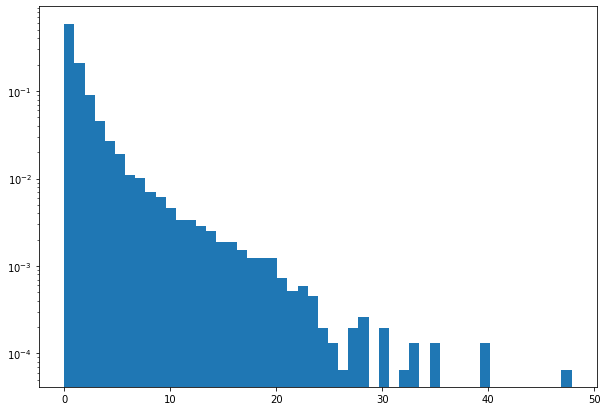

In [30]:
kts = gR_jets2['sigJetRecur_z'] * gR_jets2['sigJetRecur_jetpt'] * gR_jets2['sigJetRecur_dr12']

plt.figure(figsize=(10,7))
plt.hist(kts, bins=50, density=True)
plt.yscale('log')
plt.show

In [31]:
np.log(40)

3.6888794541139363

In [32]:
branches2

<Array [{eventWeight: [1, 1], ... 21, 1]}] type='5000 * {"eventWeight": var * fl...'>

## Now with Awkward arrays

In [33]:
# simply using awkward arrays this is also possible

jets = branches2[['sigJetPt', 'sigJetEta', 'sigJetPhi', 'sigJetM', 'sigJetArea', 'sigJetRecur_nSD', 'jetInitPDG']]
jetRecs = branches2[['sigJetRecur_dr12', 'sigJetRecur_jetpt', 'sigJetRecur_z']]

gjets = jets[jets['jetInitPDG'] == 21 ]
qjets = jets[(jets['jetInitPDG'] >= -6) & (jets['jetInitPDG'] <= 6)]

cgjets = gjets[(gjets['sigJetEta'] <= 2) & (gjets['sigJetEta'] >= -2) & (gjets['sigJetPt'] >= 130)]
cqjets = qjets[(qjets['sigJetEta'] <= 2) & (qjets['sigJetEta'] >= -2) & (qjets['sigJetPt'] >= 130)]

gRecjets = jetRecs[jets['jetInitPDG'] == 21 ]
qRecjets = jetRecs[(jets['jetInitPDG'] >= -6) & (jets['jetInitPDG'] <= 6)]

cgRecjets = gRecjets[(gjets['sigJetEta'] <= 2) & (gjets['sigJetEta'] >= -2) & (gjets['sigJetPt'] >= 130)]
cqRecjets = qRecjets[(qjets['sigJetEta'] <= 2) & (qjets['sigJetEta'] >= -2) & (qjets['sigJetPt'] >= 130)]

print(*(len(ak.to_pandas(ar)) for ar in [gjets, qjets, cgjets, cqjets]), sep='\n')

print(*(len(ak.to_pandas(ar)) for ar in [gRecjets, qRecjets, cgRecjets, cqRecjets]), sep='\n')


3252
2885
1537
1475
15939
10442
7620
5284


In [34]:
ak.to_pandas(gRecjets).head(30)

sigJetRecur_dr12  sigJetRecur_jetpt  sigJetRecur_z
entry subentry subsubentry                                                    
1     0        0                    0.147428         394.769860       0.300883
               1                    0.132673         276.618416       0.289236
               2                    0.070987         173.863196       0.255452
               3                    0.034476         115.932638       0.273700
               4                    0.022952          84.210576       0.453807
               5                    0.015130          45.998157       0.160921
               6                    0.010784          38.596652       0.320538
               7                    0.009027          26.225170       0.154865
               8                    0.002373          22.163926       0.308485
2     0        0                    0.037033         164.370537       0.122662
               1                    0.040539         144.217431       0.260949
               2                    0.034910         106.584660       0.156392
               3                    0.019276          89.916004       0.300335
               4                    0.013369          62.913511       0.433358
               5                    0.007417          35.649452       0.364830
      1        0                    0.172795         141.458658       0.378668
               1                    0.080265          77.671221       0.280836
               2                    0.066015          55.873469       0.164345
               3                    0.039067          46.692204       0.175364
               4                    0.018588          38.504405       0.169267
               5                    0.013861          31.987039       0.103371
4     0        0                    0.089091         157.076808       0.451642
               1                    0.065875          78.442010       0.181462
               2                    0.041371          61.583078       0.214179
               3                    0.017943          48.400209       0.430105
               4                    0.008222          27.584094       0.479115
5     0        0                    0.166026         123.793319       0.132175
               1                    0.088222         102.246201       0.225632
               2                    0.068327          79.176219       0.311651
               3                    0.057085          54.527350       0.294822

In [35]:
cgRecjets[1,0, 1]
    

<Record ... sigJetRecur_z: 0.289} type='{"sigJetRecur_dr12": float64, "sigJetRec...'>

In [41]:
gRecjets[2]['sigJetRecur_dr12']

<Array [[0.037, 0.0405, ... 0.0186, 0.0139]] type='2 * var * float64'>

In [52]:
branches[1]['sigJetRecur_dr12'][1]

<Array [0.155, 0.0262, ... 0.0198, 0.0106] type='5 * float64'>

In [66]:
g_list = [list(x.values()) for x in ak.to_list(cgRecjets)] # change to list form
g_list = [[y[0] for y in x] for x in g_list if x != [[],[],[]]] # remove empty entries and weird nestedness, e.g. dr[[...]]
g_list = [list(map(list, zip(*l))) for l in g_list] # transpose remainder to get [dr[...], pt[...], z[...]]


In [74]:
g_list[0]

[[0.14742806214534146, 394.76986039829825, 0.3008827287473304],
 [0.13267251891369763, 276.6184161258194, 0.2892357818409018],
 [0.0709866246926162, 173.86319618538647, 0.25545223419462365],
 [0.034476005025257196, 115.93263824595532, 0.27369964937943175],
 [0.022952153104875896, 84.21057607552014, 0.45380697809172754],
 [0.015129974329401915, 45.99815709840993, 0.1609207936109217],
 [0.010783652288699333, 38.59665231235088, 0.3205378024145048],
 [0.009026734740345217, 26.225170305403168, 0.15486468803429246],
 [0.002372734214700952, 22.163926026787312, 0.308485182541498]]

In [73]:
gRecjets[1]['sigJetRecur_z']

<Array [... 0.161, 0.321, 0.155, 0.308]] type='1 * var * float64'>